In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from biosppy.signals import ecg
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def hdf_to_dict(hdf_file):
    # Read all the keys in the file
    with pd.HDFStore(hdf_file, mode='r') as hdf:
        keys = hdf.keys()

    # Read all tables, store in dictionary
    data = {}
    for key in keys: data[key] = pd.read_hdf(hdf_file, key)
    return data

In [5]:
raw_hdf = 'D:\data\ibeat\ibeat\Subject017\SE_GENERIC_DATA_EVENT_6671_001/Subject017_Device029 2018-04-23_ibeatraw.hdf'
raw_data = hdf_to_dict(raw_hdf)

In [6]:
alg_hdf = 'D:\data\ibeat\ibeat\Subject017\SE_GENERIC_DATA_EVENT_6671_001/Subject017_Device029 2018-04-23_ibeat_alg.hdf'
alg_data = hdf_to_dict(alg_hdf)

In [8]:
ecg_data_file = 'D:\data\ibeat\eplab\Subject17_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')

In [9]:
## Run ECG Analysis on chunks:
ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]
    
    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 19 chunks


C:\Users\admin\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\admin\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\admin\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index

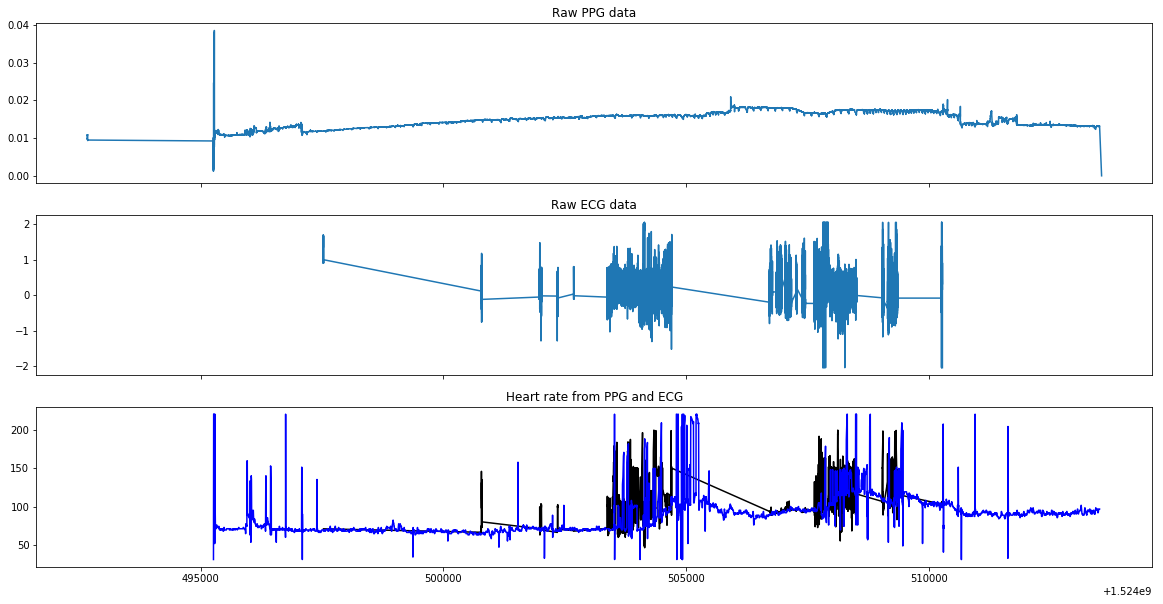

In [10]:
fig, ax = plt.subplots(3, 1, sharex = True, figsize = (20,10))
#ax[0].set_xlim([1525209240,1525209280])
# ax[0].set_ylim([0.0194,0.0195])

r_pkg1 = raw_data['/optical_streams/red/pkg1']
ax[0].plot(r_pkg1.utc, r_pkg1.pd1 / r_pkg1.drive_i / r_pkg1.gain_value)
ax[0].title.set_text('Raw PPG data')
ax[1].plot(ecg_data.utc_adjusted, ecg_data.II)
ax[1].title.set_text('Raw ECG data')

ax[2].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate', )
ax[2].plot(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_raw, label='PPG Pulse Rate', c='b')
ax[2].title.set_text('Heart rate from PPG and ECG')

NameError: name 'ecg_analysis' is not defined

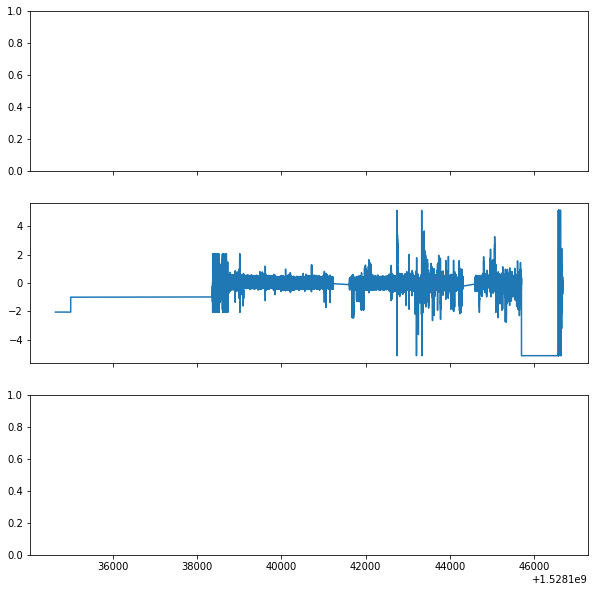

In [6]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

# Raw PPG signal - normalized by drive current and sensor gain
# g_pkg1 = raw_data['/optical_streams/green/pkg1']
# ax[0].plot(g_pkg1.utc, g_pkg1.pd1 / g_pkg1.drive_i / g_pkg1.gain_value)

# Raw ECG Signal
ax[1].plot(ecg_data.utc_adjusted, ecg_data.II)

# PPG pulse rate and ecg heart rate
ax[2].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate', )
ax[2].plot(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_track, label='PPG Pulse Rate', c='b')

# Plot raw ppg bpm as points, scaled by confidence
ax[2].scatter(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_raw, c=alg_data['/pulse_rate_alg'].bpm_conf, cmap='Reds', s=alg_data['/pulse_rate_alg'].bpm_conf * 20.0)

# ax[-1].set_xlim([ecg_data.utc_adjusted.min(), ecg_data.utc_adjusted.max()])


In [8]:
from scipy import signal
# High pass FIR filter function
def fir_highpass(x, cutoff, order):
    a = signal.firwin(order, cutoff=cutoff, window="hanning")
    # Spectral inversion
    a = -a
    a[int(order / 2)] = a[int(order / 2)] + 1
    return signal.filtfilt(a, [1], x)

C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
C:\Users\imapi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'Contact')

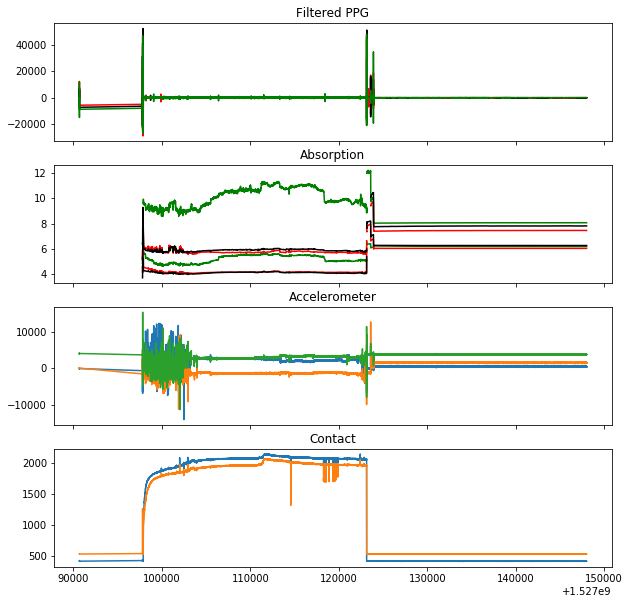

In [9]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 10))


g_pkg1 = raw_data['/optical_streams/green/pkg1']
r_pkg1 = raw_data['/optical_streams/red/pkg1']
ir_pkg1 = raw_data['/optical_streams/ir/pkg1']

# Filtered PPG signals
ax[0].plot(r_pkg1.utc, fir_highpass(r_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'r')
ax[0].plot(ir_pkg1.utc, fir_highpass(ir_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'k')
ax[0].plot(g_pkg1.utc, fir_highpass(g_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'g')
ax[0].set_title('Filtered PPG')

# Absorption signals
ax[1].plot(g_pkg1.utc, -np.log(g_pkg1.pd1/ g_pkg1.drive_i / g_pkg1.gain_value).rolling(25*15).mean(), 'g')
ax[1].plot(r_pkg1.utc, -np.log(r_pkg1.pd1/ r_pkg1.drive_i / r_pkg1.gain_value).rolling(25*15).mean(), 'r')
ax[1].plot(ir_pkg1.utc, -np.log(ir_pkg1.pd1/ ir_pkg1.drive_i / ir_pkg1.gain_value).rolling(25*15).mean(), 'k')


g_pkg2 = raw_data['/optical_streams/green/pkg2']
r_pkg2 = raw_data['/optical_streams/red/pkg2']
ir_pkg2 = raw_data['/optical_streams/ir/pkg2']
ax[1].plot(g_pkg2.utc, -np.log(g_pkg2.pd1/ g_pkg2.drive_i / g_pkg2.gain_value).rolling(50*15).mean(), 'g')
ax[1].plot(r_pkg2.utc, -np.log(r_pkg2.pd1/ r_pkg2.drive_i / r_pkg2.gain_value).rolling(25*15).mean(), 'r')
ax[1].plot(ir_pkg2.utc, -np.log(ir_pkg2.pd1/ ir_pkg2.drive_i / ir_pkg2.gain_value).rolling(25*15).mean(), 'k')
ax[1].set_title('Absorption')

# Accelerometer
accel = raw_data['/accel_data']
ax[2].plot(accel.utc, accel.x)
ax[2].plot(accel.utc, accel.y)
ax[2].plot(accel.utc, accel.z)
ax[2].set_title('Accelerometer')

# Contact data
contact = raw_data['/contact_data']
ax[3].plot(contact.utc, contact.pad1)
ax[3].plot(contact.utc, contact.pad2)
ax[3].set_title('Contact')